In [1]:
#
import mne
import os
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import pickle
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
from scipy import io
import pandas as pd

import librosa
import librosa.display as libdisp
from sklearn import preprocessing
from sklearn.mixture import GaussianMixture 
from IPython.display import clear_output

sns.set(style="darkgrid")
sns.set(font_scale=1.5)
import matplotlib as mpl
import pickle

data_path = os.path.dirname(os.getcwd())

subject_name = ['stella','juliet','shai','ayoub','lucas','simone','henry', 'julien','marion','elvira']
subject_group = [('stella','juliet'),('shai','ayoub'),('lucas','simone'),('henry', 'julien'),('marion','elvira')]
#subject_group = [1,1,2,2,3,3,4,4,5,5]
subject_gender = ['f','f','m','m','m','m','m','m','f','f']
subject_speak = [1, 2, 1, 2, 1, 2, 1, 2, 1, 2]
session_name = ['pre','duet1', 'duet2', 'duet3' ,'duet4','duet5','duet6','post']
session_words = [60,50,50,50,50,50,50,60]
eeg_label =     ['F3','C3','P3','Cz','F4','C4','P4','P7']
ema_label = ['jawaopening','lipaparature','lipProtrusion','TTCD','TMCD','TBCD']

ema_fs = 100

idx = [np.arange(1,60),np.arange(61,160),np.arange(161,260),np.arange(261,360),np.arange(361,460)
       ,np.arange(461,560),np.arange(561,660),np.arange(661,720)]

raw_fname = data_path + '/fieldtrip/data/enobio8_ferrara_french2.mat'
mat = io.loadmat(raw_fname)
pos = mat['lay']['pos'][0][0]

In [2]:
save_path = data_path + '/python/data/data.pkl'
data=pd.read_pickle(save_path)

In [3]:
# functions

def exract_audio_features(filename):
    # Set the hop length; at 22050 Hz, 512 samples ~= 23ms

    y, sr = librosa.load(filename, sr=None)

    # Compute MFCC features from the raw signal
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13,hop_length=int(0.010*sr), n_fft=int(0.025*sr))

    mfcc = preprocessing.scale(mfcc)

    # And the first-order differences (delta features)
    mfcc_delta = librosa.feature.delta(mfcc)
    mfcc_delta_delta = librosa.feature.delta(mfcc_delta)

    combined = np.vstack((mfcc,mfcc_delta,mfcc_delta_delta)) 
    
    return combined

In [ ]:
# extract MFCC from Pre and train GMM

for s in subject_name:
    A = data[(data['session']=='pre') & (data['subject']==s)]['wav'].get_values()

    features = np.asarray(())
    for f in range(0,len(A)):
        filename = data_path + '/data/wav/' + A[f]
        vector = exract_audio_features(filename)
        if features.size == 0:
            features = vector
        else:
            features = np.hstack((features, vector))
    
    save_path = data_path + '/python/data/mfcc_'+s+'.npy'
    np.save(save_path,features)
    
    

In [4]:
n_components = [4,8,16,32,64,128,256,512]
covariance_type='diag'


In [7]:
# gmm modelling

for s in subject_name:
    save_path = data_path + '/python/data/mfcc_'+s+'.npy'
    features = np.load(save_path)
    for n in n_components:
        gmm = GaussianMixture(n_components = n, max_iter  = 200, 
                          covariance_type=covariance_type, n_init = 3)
        
        gmm.fit(features.T)

        save_path = data_path + '/python/data/gmm_'+covariance_type+'_'+str(n)+'-'+ s
        pickle.dump( gmm, open( save_path, "wb" ) )

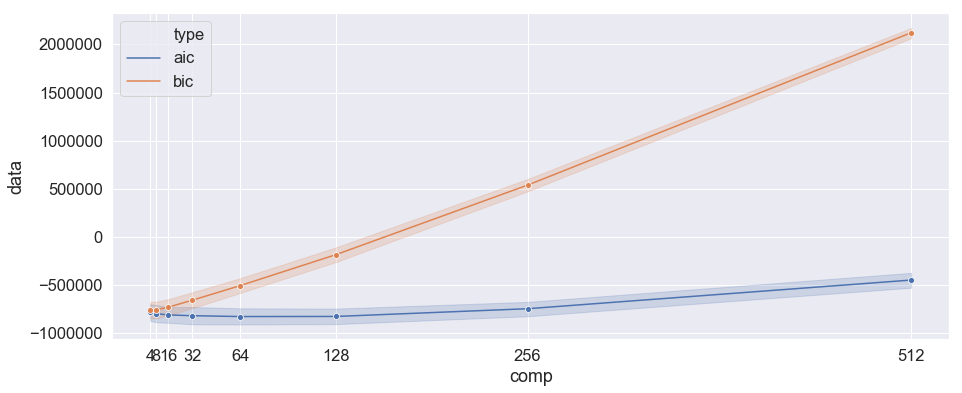

In [16]:
# check model aic bic of gmm models

GMM_models = []
for s in subject_name:
    save_path = data_path + '/python/data/mfcc_'+s+'.npy'
    features = np.load(save_path)
    
    for n in n_components:
        save_path = data_path + '/python/data/gmm_'+covariance_type+'_'+str(n)+'-'+ s
        a = pickle.load( open( save_path, "rb" ) )

        bic = a.bic(features.T)
        aic = a.aic(features.T)
        a = pd.DataFrame({'comp':[n],'subject':s,'type':'aic','data':aic})
        GMM_models.append(a)
        a = pd.DataFrame({'comp':[n],'subject':s,'type':'bic','data':bic})
        GMM_models.append(a)
        
GMM_models = pd.concat((GMM_models),axis=0)     
clear_output()

GMM_models.head()

#
f, AX = plt.subplots(figsize=(15,6))

_=sns.lineplot(data=GMM_models,x='comp',y='data',hue='type',marker='o')
_=plt.xticks(n_components)

In [5]:
# get gmm socres for all models
for n in n_components:

    GMM_models = []
    for s in subject_name:
        save_path = data_path + '/python/data/gmm_'+covariance_type+'_'+str(n)+'-'+ s
        a = pickle.load( open( save_path, "rb" ) )
        GMM_models.append(a)

    frame = []
    for i in range(0,len(data)):
        filename = data_path + '/data/wav/' + data['wav'][i]
        vector = exract_audio_features(filename)

        log_likelihood = []
        log_likelihood.append(pd.Series({'wav':data['wav'][i]}))
        for i in range(len(GMM_models)):
            gmm    = GMM_models[i]  #checking with each model one by one
            scores = np.array(gmm.score(vector.T))
            a = pd.Series({'GMM_'+subject_name[i]:scores.sum()})     
            log_likelihood.append(a)

        df = pd.concat((log_likelihood),axis=0)
        df = pd.DataFrame(df) 
        frame.append(df.T)    

    df=pd.concat((frame),axis=0)
    save_path = data_path + '/python/data/gmm_scores_'+covariance_type+'_'+str(n)+'.pkl'
    df.to_pickle(save_path)


In [25]:
GMM_components = 256
save_path = data_path + '/python/data/gmm_scores_'+str(GMM_components)+'.pkl'
gmm_scores=pd.read_pickle(save_path)

df = pd.merge(data,gmm_scores,on='wav')


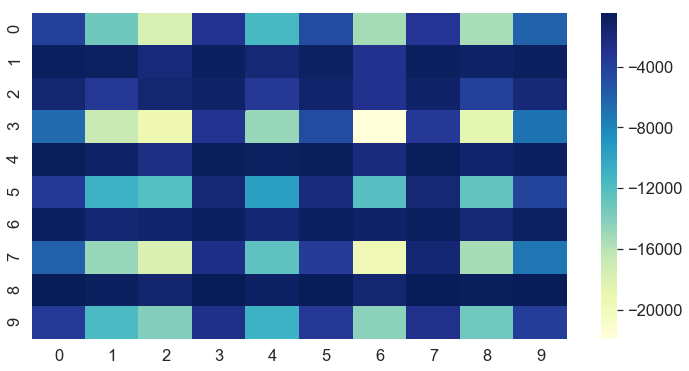

In [27]:
# plot confusion matrix
A = []
for s in subject_name:
    a = df[(df['session']=='post') & (df['subject']==s)][['GMM_stella', 'GMM_juliet', 'GMM_shai', 'GMM_ayoub',
           'GMM_lucas', 'GMM_simone', 'GMM_henry', 'GMM_julien', 'GMM_marion',
           'GMM_elvira']].get_values()
    A.append(a.mean(axis=0))
    
A = np.asarray(A)
A = A.astype(float)

sns.set(font_scale=1.5)

f, ax = plt.subplots(figsize=(12,6))
a = sns.heatmap(A,annot=True,cmap="YlGnBu")
plt.savefig('gmm_'+str(GMM_components)+'.png')
